# ABCD Extraction - Part 1

### This file contains the extraction of grayscale image, threshold image and affected pixel area. The steps performed are:

1. Convert the input image to grayscale
2. Get a histogram of the image and find the Otsu threshold values 
3. Perform binary dilation and erosion on the input image 
4. Perform masking on the image


In [15]:
import os
import numpy as np
import imageio
import cv2
from scipy import misc
from scipy import ndimage
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.image as mpimg
from PIL import Image

Define the different functions needed for the extraction

In [5]:
def threshold(image, threshold):
    assert len(image.shape) == 2, "Must be grayscale image"
    thresh = np.zeros(image.shape)
    for rownum in range(len(image)):
        for colnum in range(len(image[rownum])):    
            if image[rownum][colnum] > threshold:
                thresh[rownum][colnum] = 0 
            else:
                thresh[rownum][colnum] = 255
    return thresh

def getHistGray(image):
    assert len(image.shape) == 2, "Must be grayscale image"
    hist = np.zeros(255)
    for row in image:
        for col in row:
            hist[int(col)] += 1
    return hist

def otsu(image):
    assert len(image.shape) == 2, "Must be grayscale image"
    th = _getOtsuThreshold(image)
    return threshold(image, th)
    
    
def _getOtsuThreshold(image):
    #import measure as m
    s = 0;
    histogram = getHistGray(image)
    for i in range(len(histogram)):
        s += i * histogram[i]
    sumB = 0
    wB = 0
    wF = 0
    mB = None
    mF = None
    m = 0.0
    between = 0.0
    threshold1 = 0.0
    threshold2 = 0.0
    total = len(image.ravel())
    for i in range(len(histogram)):
        wB += histogram[i]
        if wB == 0:
            continue;
        wF = total - wB
        if (wF == 0):
            break
        sumB += i * histogram[i]
        mB = sumB / wB
        mF = (s - sumB) / wF
        between = wB * wF * ((mB - mF) ** 2)
        if between >= m :
            threshold1 = i
            if between > m :
                threshold2 = i
            m = between
    return ( threshold1 + threshold2 ) / 2.0;


def np_binary_erosion(input_array, structure=np.ones((3,3)).astype(bool)):
    
    rows, cols = input_array.shape
     
    pad_shape = (
        input_array.shape[0] + structure.shape[0] - 1, 
        input_array.shape[1] + structure.shape[1] - 1)
    input_pad_array = np.zeros(pad_shape).astype(bool)
    input_pad_array[1:rows+1,1:cols+1] = input_array
    binary_erosion = np.zeros(pad_shape).astype(bool)
    struc_mask = structure.astype(bool)
    for row in range(len(image)):
        for col in range(len(image[row])):
            binary_erosion[row+1,col+1] = np.min(
                input_pad_array[row:row+3, col:col+3][struc_mask])
    return binary_erosion[1:rows+1,1:cols+1]

def np_binary_dilation(img):
    out=np.array(img)
    h=img.shape[0]
    w=img.shape[1]
    D=np.zeros((h,w),dtype=int)
    for i in np.arange(2,h-2):
            for j in np.arange(2,w-2):
                a=img[i][j]
                if a.any():
                    out[i+1][j]=255
                    out[i][j+1]=255
    return out



def masking(image,mask):
    new_img=np.array(image)
    for row in range(len(image)):
        for col in range(len(image[row])):
            if mask[row,col]==0:
                new_img[row,col]=0
            if mask[row,col]==1:
                new_img[row,col]=image[row,col]
    return new_img

def convertToGreyScale(image):
    
    def getWeightedAvg(pixel):
        return 0.299*pixel[0] + 0.587*pixel[1] + 0.114*pixel[2]        
        
    grey = np.zeros(image.shape[0:-1])
    for rownum in range(len(image)):
        for colnum in range(len(image[rownum])):
                grey[rownum][colnum] = getWeightedAvg(image[rownum][colnum])
        
    return grey


This shows the input image, threshold image , grayscale image and the final image for a sample benign image

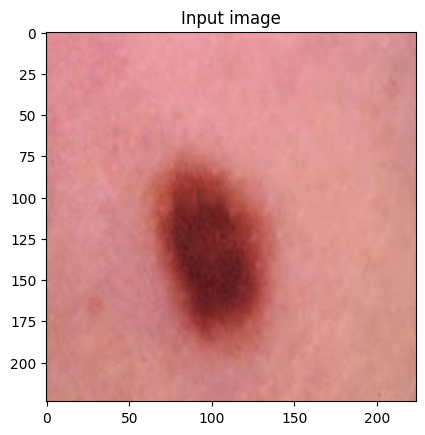

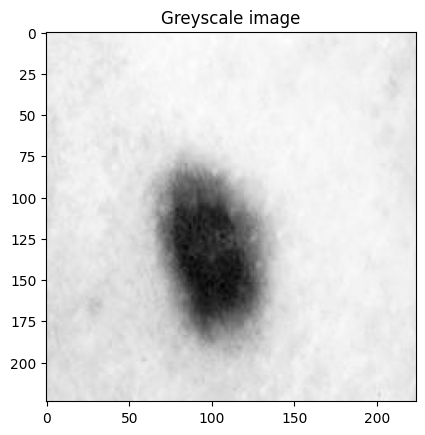

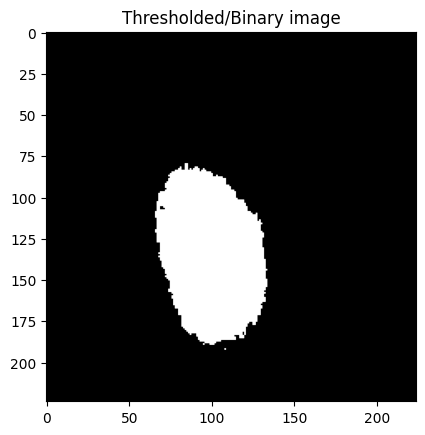

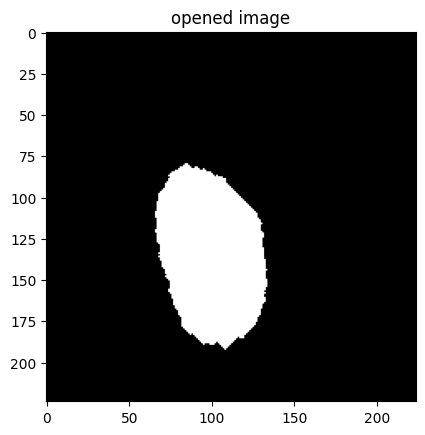

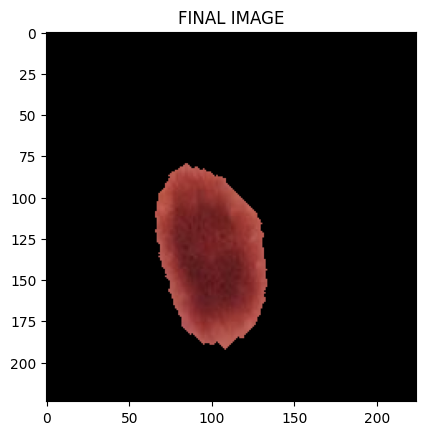

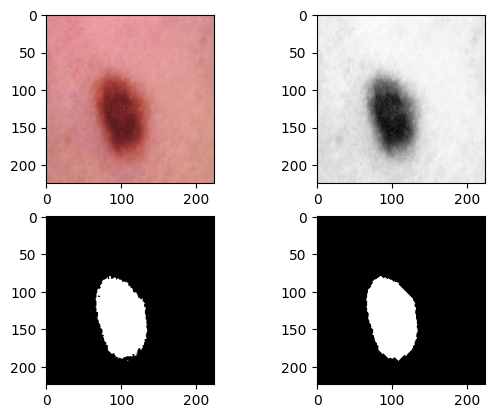

In [17]:
image = imageio.v2.imread('final/benign/1 (28).jpg')
plt.title("Input image")
plt.imshow(image)
plt.show()       
grey = convertToGreyScale(image)
plt.title("Greyscale image")
plt.imshow(grey,cmap=cm.Greys_r)
plt.show()

thresh = otsu(grey)
plt.title("Thresholded/Binary image")
plt.imshow(thresh, cmap = cm.Greys_r)
plt.show()  
dilimg=ndimage.binary_dilation(thresh)
for x in range(25):
    dilimg=ndimage.binary_dilation(dilimg)
erimg=ndimage.binary_erosion(dilimg)
for x in range(25):
    erimg=ndimage.binary_erosion(erimg)
plt.title("opened image")
plt.imshow(erimg,cmap=cm.Greys_r)
plt.show()
thresh = Image.fromarray(np.uint8(thresh))
thresh = thresh.convert('L')
imageio.imwrite('threshold.jpg', thresh)

new_img=masking(image,erimg)
plt.title("FINAL IMAGE")
plt.imshow(new_img)
plt.show()
imageio.imwrite('Result.jpg', new_img)
    

fig=plt.figure()
ax1=fig.add_subplot(2,2,1)
ax1.imshow(image)
ax2=fig.add_subplot(2,2,2)
ax2.imshow(grey,cmap=cm.Greys_r)
ax3=fig.add_subplot(2,2,3)
ax3.imshow(thresh,cmap=cm.Greys_r)
ax4=fig.add_subplot(2,2,4)
ax4.imshow(erimg,cmap=cm.Greys_r)
plt.show()    